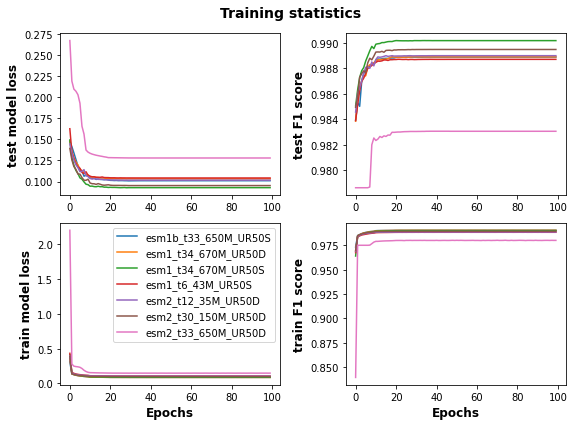

In [1]:
model_list = ['esm1b_t33_650M_UR50S', 'esm1_t34_670M_UR50D', 'esm1_t34_670M_UR50S',
                  'esm1_t6_43M_UR50S', 'esm2_t12_35M_UR50D', 'esm2_t30_150M_UR50D',
                  'esm2_t33_650M_UR50D', 'esm2_t6_8M_UR50D']

import matplotlib.pyplot as plt
import pandas as pd
import os
fig, ax = plt.subplots(2,2, figsize=(8, 6))
for model_name in model_list:
    if model_name+'.csv' in os.listdir('checkpoints'):
        df = pd.read_csv('checkpoints/%s.csv'%(model_name))
        ax[0][0].plot(range(len(df['net_loss_test'])), df['net_loss_test'], label=model_name)
        ax[0][0].set_ylabel('test model loss', fontsize=12, fontweight='bold')
        
        ax[0][1].plot(range(len(df['net_f1_test'])), df['net_f1_test'], label=model_name)
        ax[0][1].set_ylabel('test F1 score', fontsize=12, fontweight='bold')

        ax[1][0].plot(range(len(df['net_loss_train'])), df['net_loss_train'], label=model_name)
        ax[1][0].set_ylabel('train model loss', fontsize=12, fontweight='bold')
        ax[1][0].legend()

        ax[1][1].plot(range(len(df['net_f1_train'])), df['net_f1_train'], label=model_name)
        ax[1][1].set_ylabel('train F1 score', fontsize=12, fontweight='bold')
        
        ax[1][1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
        ax[1][0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
        # # ax[0].legend()
fig.suptitle('Training statistics', fontsize=14, fontweight='bold')
plt.tight_layout()


# Inference

In [1]:
from utils import ProtEmbDataset
model_name = 'esm1_t6_43M_UR50S'
protein_dataset = ProtEmbDataset(model_name+'_batch128')

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np

# Create a validation and training set
samples_count = len(protein_dataset)
all_samples_indexes = list(range(samples_count))
np.random.shuffle(all_samples_indexes)

val_ratio = 0.2
val_end = int(samples_count * val_ratio)
val_indexes = all_samples_indexes[0:val_end]
train_indexes = all_samples_indexes[val_end:]
assert len(val_indexes) + len(train_indexes) == samples_count , 'the split is not valid' 

sampler_train = data.SubsetRandomSampler(train_indexes)
sampler_val = data.SubsetRandomSampler(val_indexes)

dataloader_val = DataLoader(protein_dataset, batch_size=1, sampler = sampler_val, num_workers=4)
dataloader_train = DataLoader(protein_dataset, batch_size=1, sampler = sampler_train, num_workers=4)

len(dataloader_val), dataloader_val.dataset[0][0].shape

/home/dell4/miniconda3/envs/ion/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(43, torch.Size([42005, 768]))

In [3]:
# Numnber of datapoints in val set
count = 0
from tqdm import tqdm
for embs, labels in tqdm(dataloader_val):
    count+=len(embs[0])
count

100%|██████████| 43/43 [00:11<00:00,  3.81it/s]


1823508

In [2]:
import torch
import torch.nn as nn
from training.models import IonicProtein

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = IonicProtein(dataloader_val.dataset[0][0].shape[1]).to(device)
trained_model.load_state_dict(torch.load('../checkpoints/%s.pt'%(model_name)))
trained_model.eval()

count=0
for datapoint, label in dataloader_val:
    predictions = trained_model(datapoint[0].to(device), mask=None)
    break
    # count+=1
    # if count==3:
    #     break

import collections
m = nn.Sigmoid()
for i, ion in zip(range(len(label.keys())), label.keys()):
    print(ion, collections.Counter(torch.round(m(torch.stack(predictions))).cpu().data.numpy()[i]), collections.Counter(label[ion][0].cpu().data.numpy()))

CA Counter({0.0: 41789, 1.0: 3}) Counter({0: 41792})
CO Counter({0.0: 41792}) Counter({0: 41792})
CU Counter({0.0: 41792}) Counter({0: 41792})
FE2 Counter({0.0: 41792}) Counter({0: 41792})
FE Counter({0.0: 41783, 1.0: 9}) Counter({0: 41792})
MG Counter({0.0: 41760, 1.0: 32}) Counter({0: 41792})
MN Counter({0.0: 41577, 1.0: 215}) Counter({0: 41178, 1: 614})
PO4 Counter({0.0: 41792}) Counter({0: 41792})
SO4 Counter({0.0: 41792}) Counter({0: 41792})
ZN Counter({0.0: 41754, 1.0: 38}) Counter({0: 41792})
null Counter({1.0: 41284, 0.0: 508}) Counter({1.0: 41178, 0.0: 614})


CA Error
CO Error
CU Error
FE2 Error
FE Error
MG Error
Plotting ROC-PR for MN


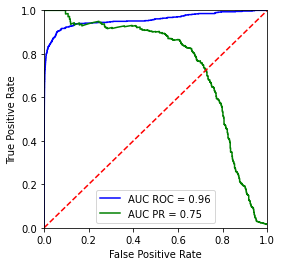

PO4 Error
SO4 Error
ZN Error
Plotting ROC-PR for null


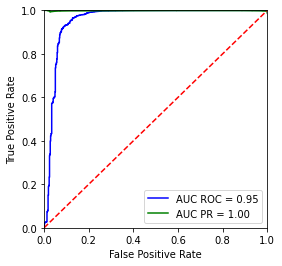

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
for ion, i in zip(label.keys(), range(len(label.keys()))):
    try:
        roc_auc = roc_auc_score(label[ion][0].cpu().data.numpy(), predictions[i].cpu().data.numpy())
        fpr, tpr, threshold = roc_curve(label[ion][0].cpu().data.numpy(), predictions[i].cpu().data.numpy())
        precision, recall, thresholds = precision_recall_curve(label[ion][0].cpu().data.numpy(), predictions[i].cpu().data.numpy())
        aupr = average_precision_score(label[ion][0].cpu().data.numpy(), predictions[i].cpu().data.numpy())
        print('Plotting ROC-PR for', ion)

        # method I: plt
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1, figsize=(4, 4))
        #ax.title('Receiver Operating Characteristic', fontweight='bold')
        ax.plot(fpr, tpr, 'b', label = 'AUC ROC = %0.2f' % roc_auc)
        ax.plot(recall, precision, 'g', label = 'AUC PR = %0.2f' % aupr)
        ax.legend()
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        plt.show()
    except:
        print(ion, 'Error')